#Import Library

In [162]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

pd.set_option('display.max_columns', None)


#Data Load: Load banglore home prices into a dataframe

In [163]:
df1 = pd.read_csv("/content/Bengaluru_House_Data.csv")
df1.head()

,area_type,availability,location,size,society,total_sqft,bath,balcony,price
0,Super built-up Area,19-Dec,Electronic City Phase II,2 BHK,Coomee,1056,2.0,1.0,39.07
1,Plot Area,Ready To Move,Chikka Tirupathi,4 Bedroom,Theanmp,2600,5.0,3.0,120.00
2,Built-up Area,Ready To Move,Uttarahalli,3 BHK,NaN,1440,2.0,3.0,62.00
3,Super built-up Area,Ready To Move,Lingadheeranahalli,3 BHK,Soiewre,1521,3.0,1.0,95.00
4,Super built-up Area,Ready To Move,Kothanur,2 BHK,NaN,1200,2.0,1.0,51.00


In [164]:
df1.shape

(13320, 9)

In [165]:
df1.columns

Index(['area_type', 'availability', 'location', 'size', 'society',
       'total_sqft', 'bath', 'balcony', 'price'],
      dtype='object')

In [166]:
df1['area_type'].unique()

array(['Super built-up  Area', 'Plot  Area', 'Built-up  Area',
       'Carpet  Area'], dtype=object)

In [167]:
df1['area_type'].value_counts()

,count
area_type,
Super built-up Area,8790
Built-up Area,2418
Plot Area,2025
Carpet Area,87


In [168]:
df2 = df1.drop(['area_type','society','balcony','availability'],axis='columns')
df2.shape

(13320, 5)

#Data Cleaning: Handle NA values

In [169]:
df2.isnull().sum()

,0
location,1
size,16
total_sqft,0
bath,73
price,0


In [170]:
df2.shape

(13320, 5)

In [171]:
df3 = df2.dropna()
df3.isnull().sum()

,0
location,0
size,0
total_sqft,0
bath,0
price,0


In [172]:
df3.shape

(13246, 5)

#Feature Engineering

Add new feature(integer) for bhk (Bedrooms Hall Kitchen)

In [173]:
df3['bhk'] = df3['size'].apply(lambda x: int(x.split(' ')[0]))
df3.bhk.unique()

/tmp/ipython-input-2716584372.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df3['bhk'] = df3['size'].apply(lambda x: int(x.split(' ')[0]))


array([ 2,  4,  3,  6,  1,  8,  7,  5, 11,  9, 27, 10, 19, 16, 43, 14, 12,
       13, 18])

Explore total_sqft feature


In [174]:
def is_float(x):
    try:
        float(x)
    except:
        return False
    return True

In [175]:
df3[~df3['total_sqft'].apply(is_float)].head(10)

,location,size,total_sqft,bath,price,bhk
30,Yelahanka,4 BHK,2100 - 2850,4.0,186.000,4
122,Hebbal,4 BHK,3067 - 8156,4.0,477.000,4
137,8th Phase JP Nagar,2 BHK,1042 - 1105,2.0,54.005,2
165,Sarjapur,2 BHK,1145 - 1340,2.0,43.490,2
188,KR Puram,2 BHK,1015 - 1540,2.0,56.800,2
410,Kengeri,1 BHK,34.46Sq. Meter,1.0,18.500,1
549,Hennur Road,2 BHK,1195 - 1440,2.0,63.770,2
648,Arekere,9 Bedroom,4125Perch,9.0,265.000,9
661,Yelahanka,2 BHK,1120 - 1145,2.0,48.130,2
672,Bettahalsoor,4 Bedroom,3090 - 5002,4.0,445.000,4


Above shows that total_sqft can be a range (e.g. 2100-2850). For such case we can just take average of min and max value in the range. There are other cases such as 34.46Sq. Meter which one can convert to square ft using unit conversion. I am going to just drop such corner cases to keep things simple

In [176]:
def convert_sqft_to_num(x):
    tokens = x.split('-')
    if len(tokens) == 2:
        return (float(tokens[0])+float(tokens[1]))/2
    try:
        return float(x)
    except:
        return None

In [177]:
df4 = df3.copy()
df4.total_sqft = df4.total_sqft.apply(convert_sqft_to_num)
df4 = df4[df4.total_sqft.notnull()]
df4.head(2)

,location,size,total_sqft,bath,price,bhk
0,Electronic City Phase II,2 BHK,1056.0,2.0,39.07,2
1,Chikka Tirupathi,4 Bedroom,2600.0,5.0,120.00,4


For below row, it shows total_sqft as 2475 which is an average of the range 2100-2850

In [178]:
df4.loc[30]

,30
location,Yelahanka
size,4 BHK
total_sqft,2475.0
bath,4.0
price,186.0
bhk,4


In [179]:
(2100+2850)/2

2475.0

#Feature Engineering

Add new feature called price per square feet

In [180]:
df5 = df4.copy()
df5['price_per_sqft'] = df5['price']*100000/df5['total_sqft']
df5.head()

,location,size,total_sqft,bath,price,bhk,price_per_sqft
0,Electronic City Phase II,2 BHK,1056.0,2.0,39.07,2,3699.810606
1,Chikka Tirupathi,4 Bedroom,2600.0,5.0,120.00,4,4615.384615
2,Uttarahalli,3 BHK,1440.0,2.0,62.00,3,4305.555556
3,Lingadheeranahalli,3 BHK,1521.0,3.0,95.00,3,6245.890861
4,Kothanur,2 BHK,1200.0,2.0,51.00,2,4250.000000


In [181]:
df5_stats = df5['price_per_sqft'].describe()
df5_stats

,price_per_sqft
count,1.320000e+04
mean,7.920759e+03
std,1.067272e+05
min,2.678298e+02
25%,4.267701e+03
50%,5.438331e+03
75%,7.317073e+03
max,1.200000e+07


In [182]:
df5.to_csv("bhp.csv",index=False)

Examine locations which is a categorical variable. We need to apply dimensionality reduction technique here to reduce number of locations

In [183]:
df5.location = df5.location.apply(lambda x: x.strip())
location_stats = df5['location'].value_counts(ascending=False)
location_stats

,count
location,
Whitefield,533
Sarjapur Road,392
Electronic City,304
Kanakpura Road,264
Thanisandra,235
...,...
Zuzuvadi,1
Chellikere,1
Jakkasandra,1


In [184]:
location_stats.values.sum()

np.int64(13200)

In [185]:
len(location_stats[location_stats>10])

240

In [186]:
len(location_stats)

1287

In [187]:
len(location_stats[location_stats<=10])

1047

#Dimensionality Reduction

Any location having less than 10 data points should be tagged as "other" location. This way number of categories can be reduced by huge amount. Later on when we do one hot encoding, it will help us with having fewer dummy columns

In [188]:
location_stats_less_than_10 = location_stats[location_stats<=10]
location_stats_less_than_10

,count
location,
Ganga Nagar,10
Kalkere,10
Dairy Circle,10
1st Block Koramangala,10
Sector 1 HSR Layout,10
...,...
Zuzuvadi,1
Chellikere,1
Jakkasandra,1


In [189]:
len(df5.location.unique())

1287

In [190]:
df5.location = df5.location.apply(lambda x: 'other' if x in location_stats_less_than_10 else x)
len(df5.location.unique())

241

In [191]:
df5.head(10)

,location,size,total_sqft,bath,price,bhk,price_per_sqft
0,Electronic City Phase II,2 BHK,1056.0,2.0,39.07,2,3699.810606
1,Chikka Tirupathi,4 Bedroom,2600.0,5.0,120.00,4,4615.384615
2,Uttarahalli,3 BHK,1440.0,2.0,62.00,3,4305.555556
3,Lingadheeranahalli,3 BHK,1521.0,3.0,95.00,3,6245.890861
4,Kothanur,2 BHK,1200.0,2.0,51.00,2,4250.000000
5,Whitefield,2 BHK,1170.0,2.0,38.00,2,3247.863248
6,Old Airport Road,4 BHK,2732.0,4.0,204.00,4,7467.057101
7,Rajaji Nagar,4 BHK,3300.0,4.0,600.00,4,18181.818182
8,Marathahalli,3 BHK,1310.0,3.0,63.25,3,4828.244275
9,other,6 Bedroom,1020.0,6.0,370.00,6,36274.509804


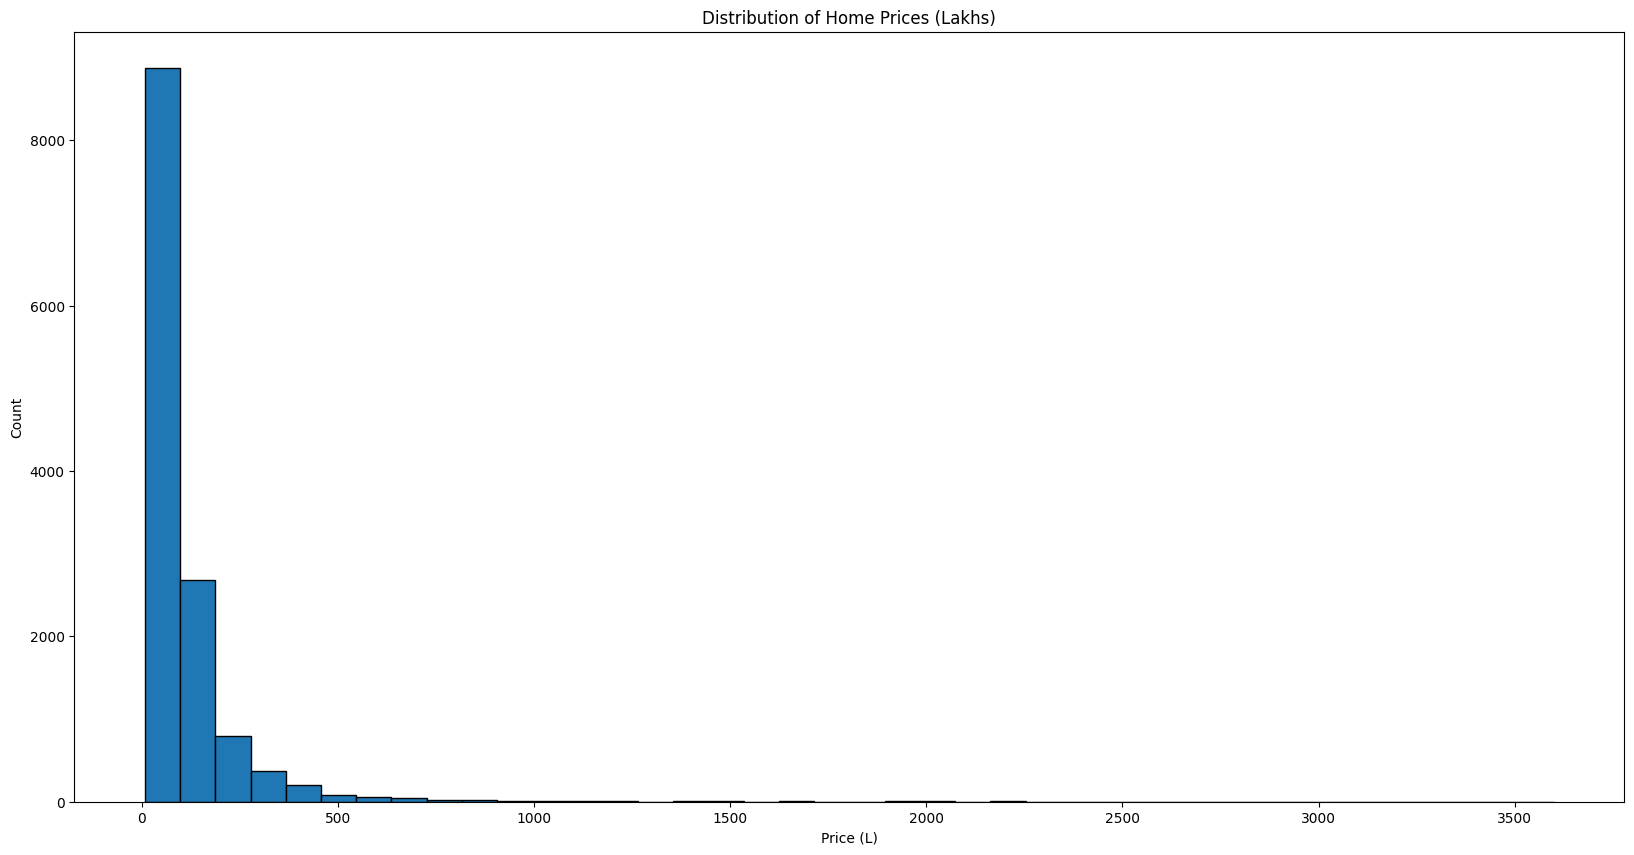

In [192]:
# Cell 5: EDA Visualizations
# 1) Price distribution
plt.hist(df5["price"], bins=40, edgecolor="black")
plt.title("Distribution of Home Prices (Lakhs)")
plt.xlabel("Price (L)")
plt.ylabel("Count")
plt.show()

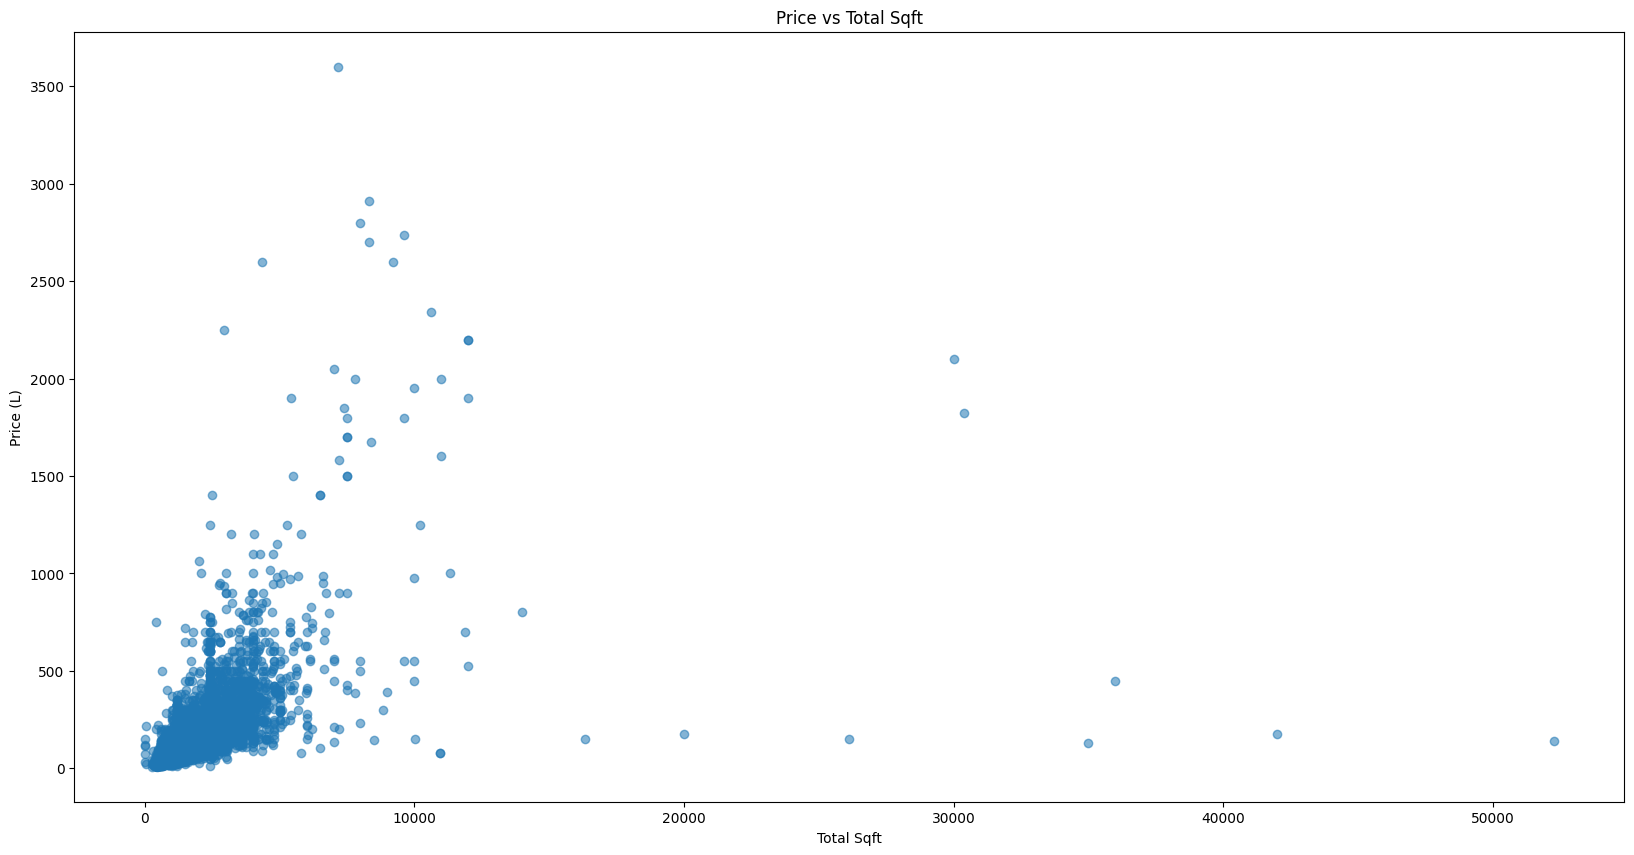

In [193]:
# 2) Price vs total_sqft
plt.scatter(df5["total_sqft"], df5["price"], alpha=0.55)
plt.title("Price vs Total Sqft")
plt.xlabel("Total Sqft")
plt.ylabel("Price (L)")
plt.show()

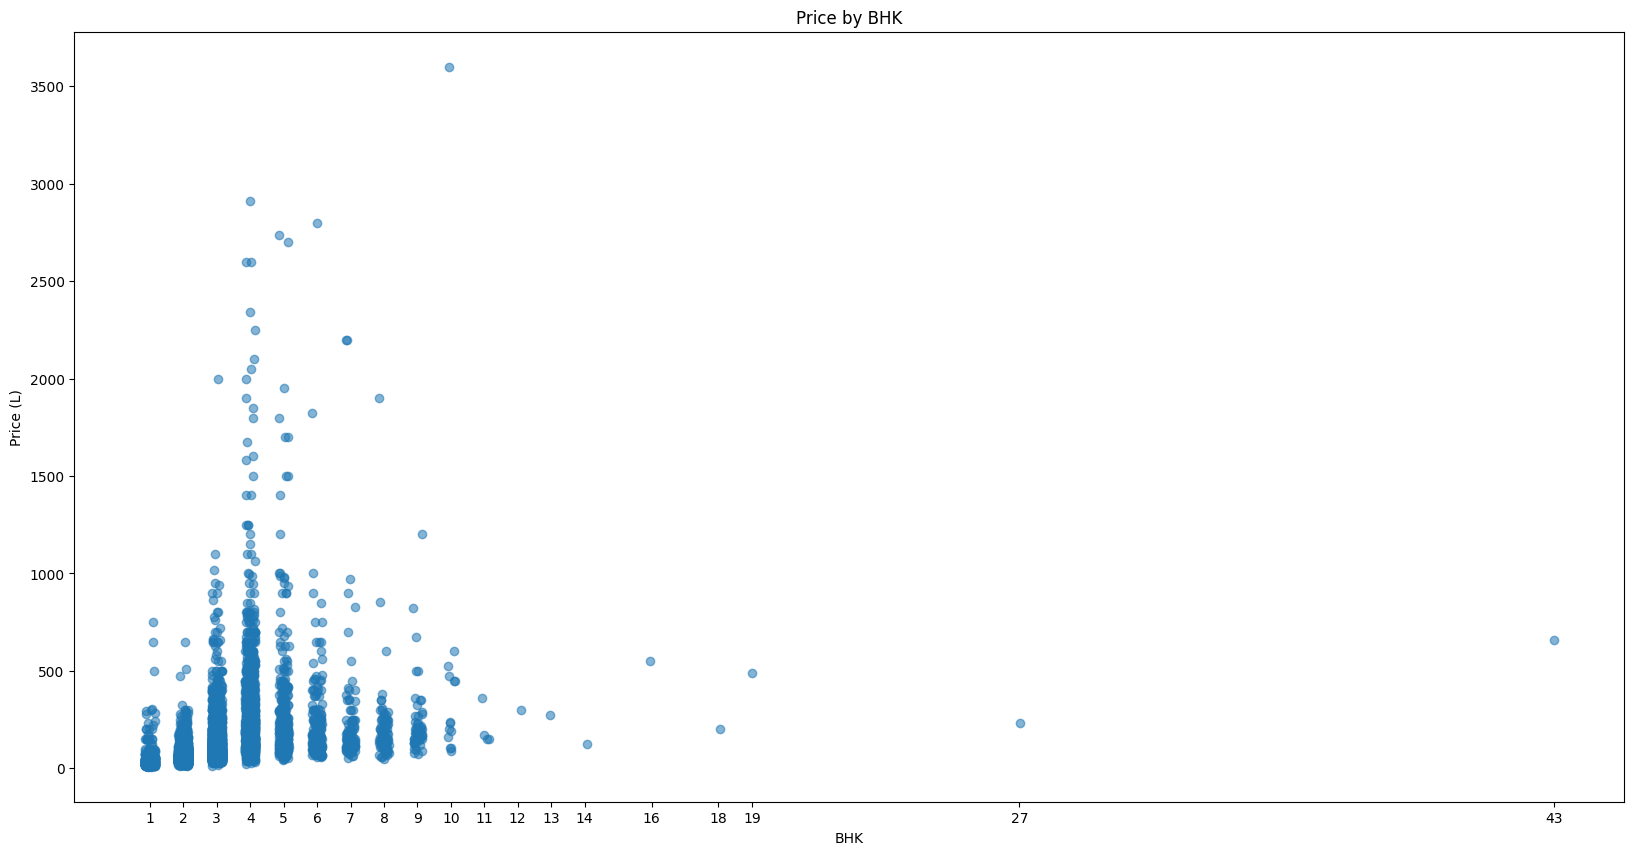

In [194]:
# 3) Price by BHK (jittered)
jitter = np.random.uniform(-0.15, 0.15, size=len(df5))
plt.scatter(df5["bhk"] + jitter, df5["price"], alpha=0.55)
plt.title("Price by BHK")
plt.xlabel("BHK")
plt.ylabel("Price (L)")
plt.xticks(sorted(df5["bhk"].unique()))
plt.show()

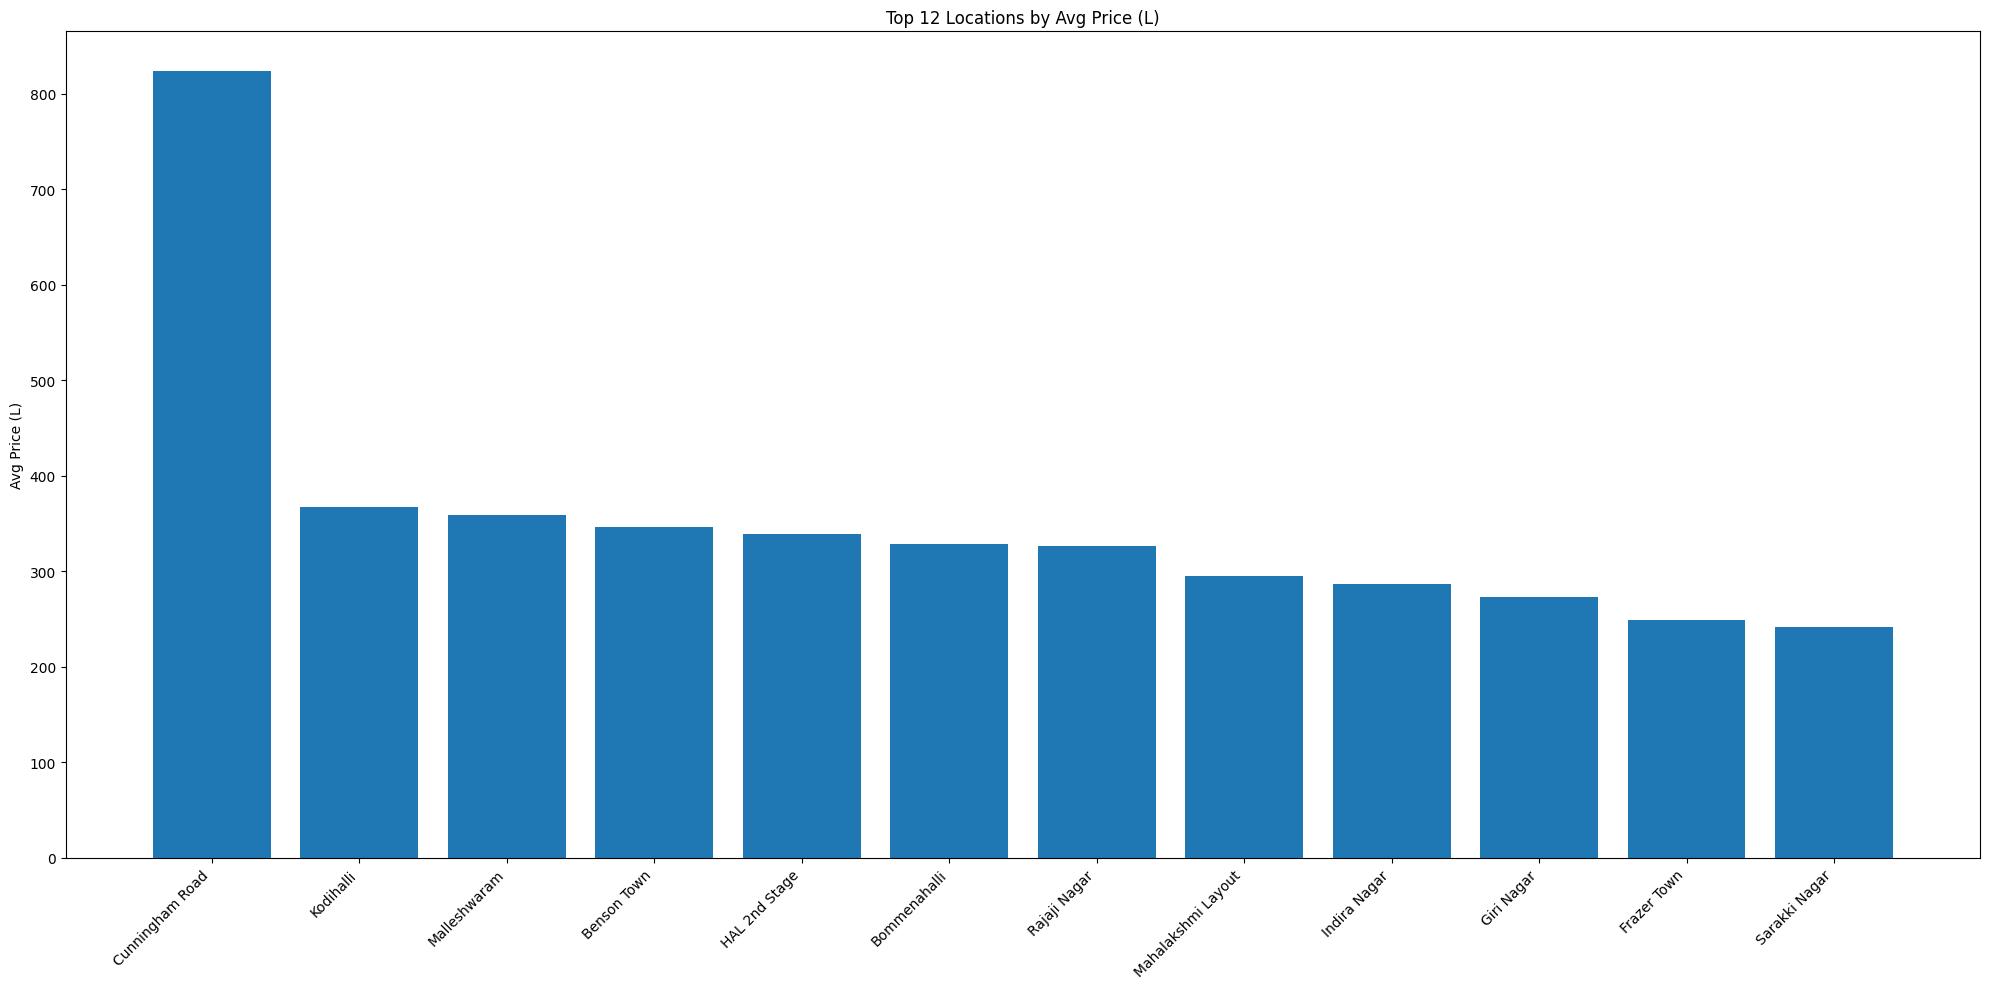

In [195]:
# 4) Top 12 locations by avg price
top = df5.groupby("location")["price"].mean().sort_values(ascending=False).head(12)
plt.bar(top.index, top.values)
plt.title("Top 12 Locations by Avg Price (L)")
plt.ylabel("Avg Price (L)")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

#Outlier Removal Using Business Logic

As a data scientist when you have a conversation with your business manager (who has expertise in real estate), he will tell you that normally square ft per bedroom is 300 (i.e. 2 bhk apartment is minimum 600 sqft. If you have for example 400 sqft apartment with 2 bhk than that seems suspicious and can be removed as an outlier. We will remove such outliers by keeping our minimum thresold per bhk to be 300 sqft

In [196]:
df5[df5.total_sqft/df5.bhk<300].head()

,location,size,total_sqft,bath,price,bhk,price_per_sqft
9,other,6 Bedroom,1020.0,6.0,370.0,6,36274.509804
45,HSR Layout,8 Bedroom,600.0,9.0,200.0,8,33333.333333
58,Murugeshpalya,6 Bedroom,1407.0,4.0,150.0,6,10660.980810
68,Devarachikkanahalli,8 Bedroom,1350.0,7.0,85.0,8,6296.296296
70,other,3 Bedroom,500.0,3.0,100.0,3,20000.000000


Check above data points. We have 6 bhk apartment with 1020 sqft. Another one is 8 bhk and total sqft is 600. These are clear data errors that can be removed safely

In [197]:
df5.shape

(13200, 7)

In [198]:
df6 = df5[~(df5.total_sqft/df5.bhk<300)]
df6.shape

(12456, 7)

#Outlier Removal Using Standard Deviation and Mean

In [199]:
df6.price_per_sqft.describe()

,price_per_sqft
count,12456.000000
mean,6308.502826
std,4168.127339
min,267.829813
25%,4210.526316
50%,5294.117647
75%,6916.666667
max,176470.588235


Here we find that min price per sqft is 267 rs/sqft whereas max is 12000000, this shows a wide variation in property prices. We should remove outliers per location using mean and one standard deviation

In [200]:
def remove_pps_outliers(df):
    df_out = pd.DataFrame()
    for key, subdf in df.groupby('location'):
        m = np.mean(subdf.price_per_sqft)
        st = np.std(subdf.price_per_sqft)
        reduced_df = subdf[(subdf.price_per_sqft>(m-st)) & (subdf.price_per_sqft<=(m+st))]
        df_out = pd.concat([df_out,reduced_df],ignore_index=True)
    return df_out
df7 = remove_pps_outliers(df6)
df7.shape

(10242, 7)

Let's check if for a given location how does the 2 BHK and 3 BHK property prices look like

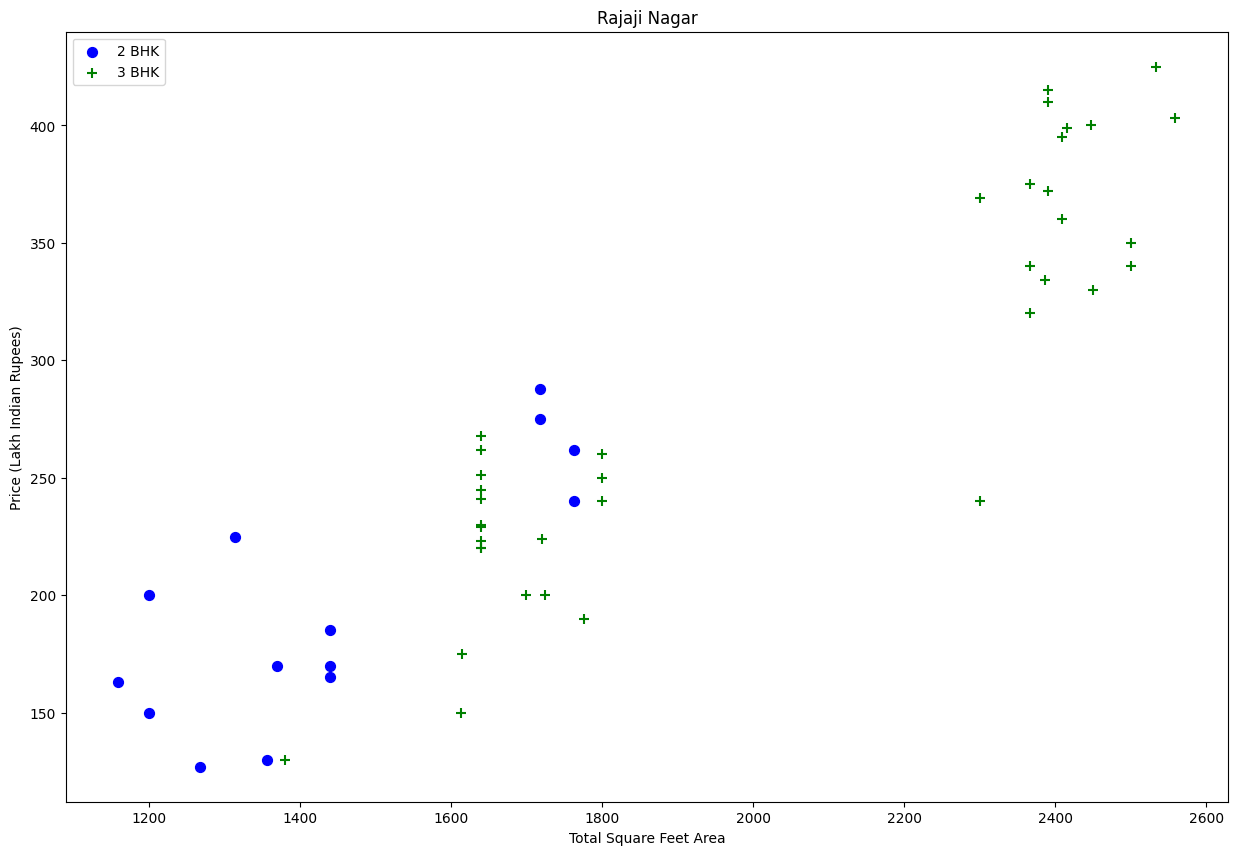

In [201]:
def plot_scatter_chart(df,location):
    bhk2 = df[(df.location==location) & (df.bhk==2)]
    bhk3 = df[(df.location==location) & (df.bhk==3)]
    matplotlib.rcParams['figure.figsize'] = (15,10)
    plt.scatter(bhk2.total_sqft,bhk2.price,color='blue',label='2 BHK', s=50)
    plt.scatter(bhk3.total_sqft,bhk3.price,marker='+', color='green',label='3 BHK', s=50)
    plt.xlabel("Total Square Feet Area")
    plt.ylabel("Price (Lakh Indian Rupees)")
    plt.title(location)
    plt.legend()

plot_scatter_chart(df7,"Rajaji Nagar")

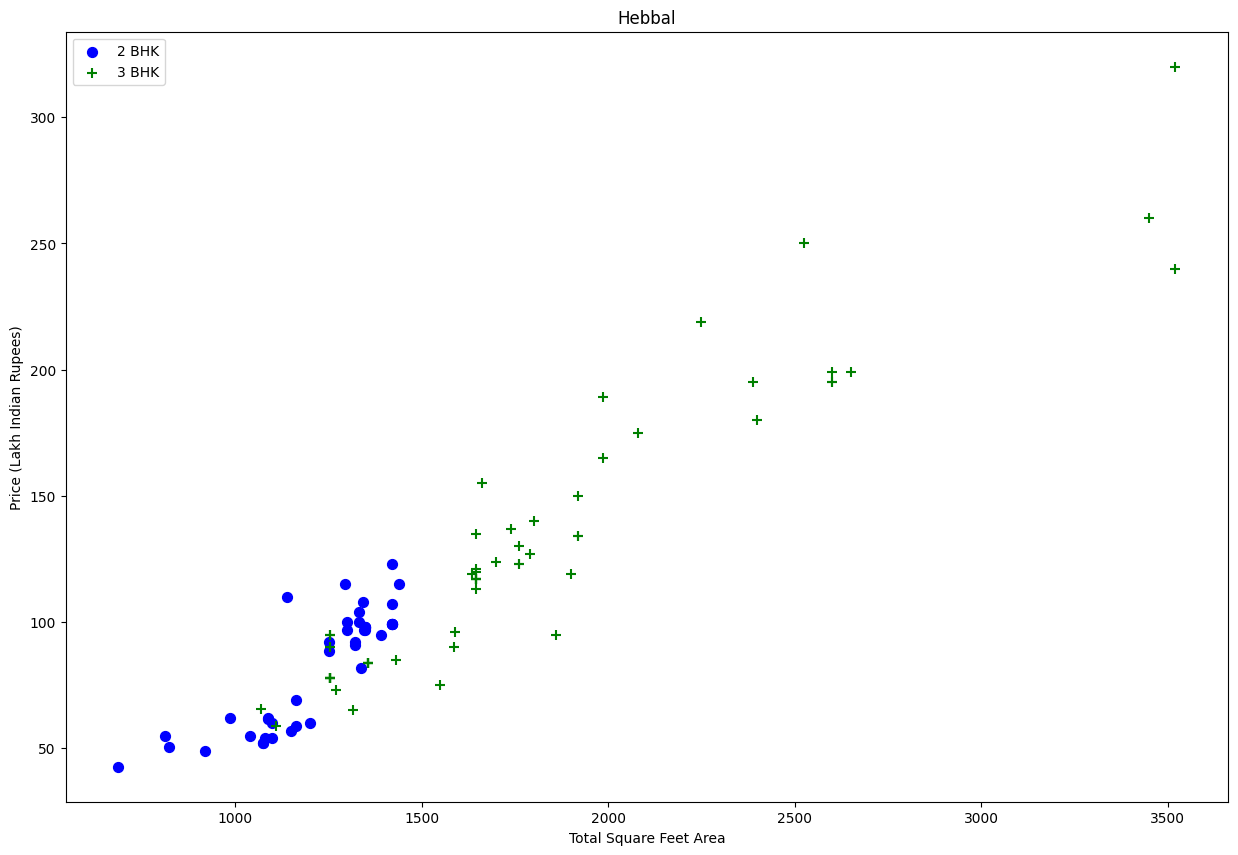

In [202]:
plot_scatter_chart(df7,"Hebbal")

We should also remove properties where for same location, the price of (for example) 3 bedroom apartment is less than 2 bedroom apartment (with same square ft area). What we will do is for a given location, we will build a dictionary of stats per bhk, i.e.

    {
    '1' : {
        'mean': 4000,
        'std: 2000,
        'count': 34
    },
    '2' : {
        'mean': 4300,
        'std: 2300,
        'count': 22
    },    }

Now we can remove those 2 BHK apartments whose price_per_sqft is less than mean price_per_sqft of 1 BHK apartment

In [203]:
def remove_bhk_outliers(df):
    exclude_indices = np.array([])
    for location, location_df in df.groupby('location'):
        bhk_stats = {}
        for bhk, bhk_df in location_df.groupby('bhk'):
            bhk_stats[bhk] = {
                'mean': np.mean(bhk_df.price_per_sqft),
                'std': np.std(bhk_df.price_per_sqft),
                'count': bhk_df.shape[0]
            }
        for bhk, bhk_df in location_df.groupby('bhk'):
            stats = bhk_stats.get(bhk-1)
            if stats and stats['count']>5:
                exclude_indices = np.append(exclude_indices, bhk_df[bhk_df.price_per_sqft<(stats['mean'])].index.values)
    return df.drop(exclude_indices,axis='index')
df8 = remove_bhk_outliers(df7)
# df8 = df7.copy()
df8.shape

(7317, 7)

Plot same scatter chart again to visualize price_per_sqft for 2 BHK and 3 BHK properties

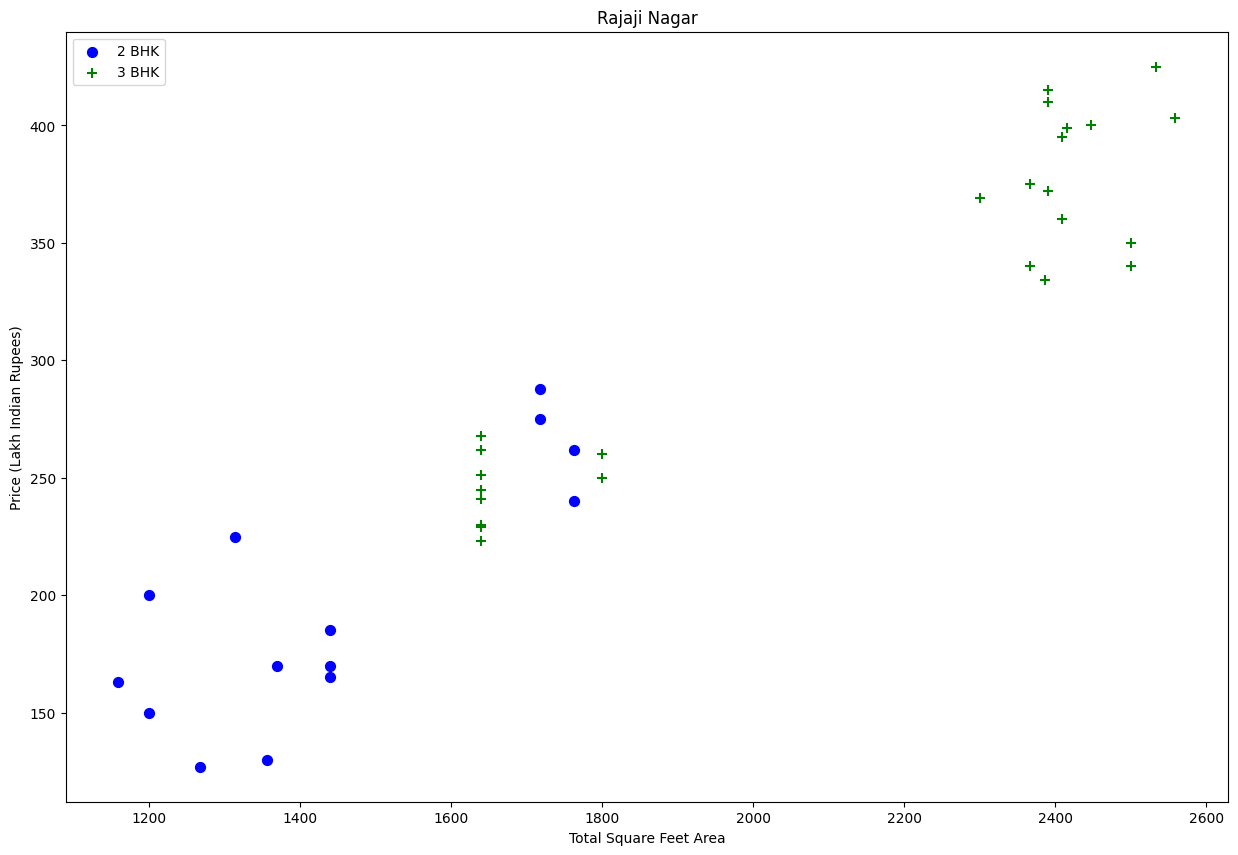

In [204]:
plot_scatter_chart(df8,"Rajaji Nagar")

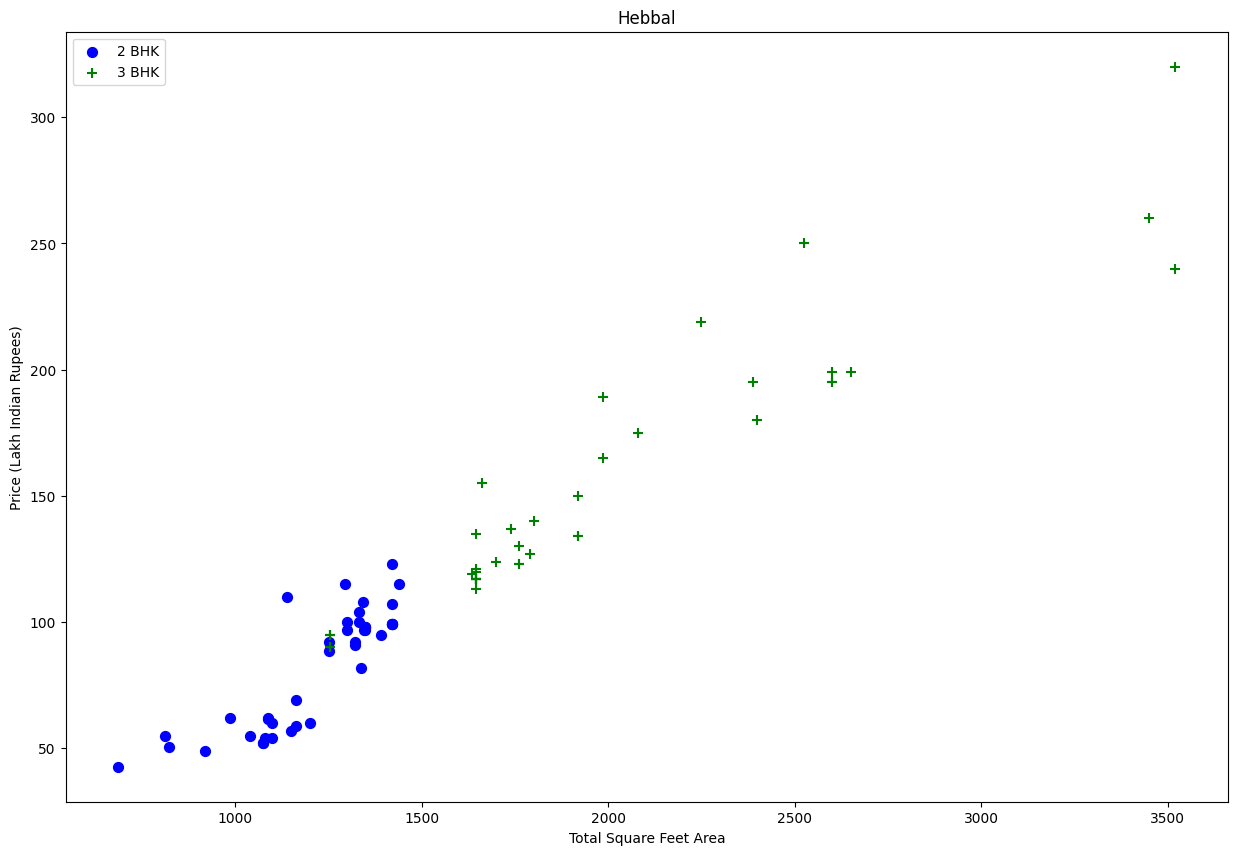

In [205]:
plot_scatter_chart(df8,"Hebbal")

In [206]:
def remove_bhk_outliers(df):
    exclude_indices = np.array([])
    for location, location_df in df.groupby('location'):
        bhk_stats = {}
        for bhk, bhk_df in location_df.groupby('bhk'):
            bhk_stats[bhk] = {
                'mean': np.mean(bhk_df.price_per_sqft),
                'std': np.std(bhk_df.price_per_sqft),
                'count': bhk_df.shape[0]
            }
        for bhk, bhk_df in location_df.groupby('bhk'):
            stats = bhk_stats.get(bhk-1)
            if stats and stats['count']>5:
                exclude_indices = np.append(exclude_indices, bhk_df[bhk_df.price_per_sqft<(stats['mean'])].index.values)
    return df.drop(exclude_indices,axis='index')
df8 = remove_bhk_outliers(df7)
# df8 = df7.copy()
df8.shape

(7317, 7)

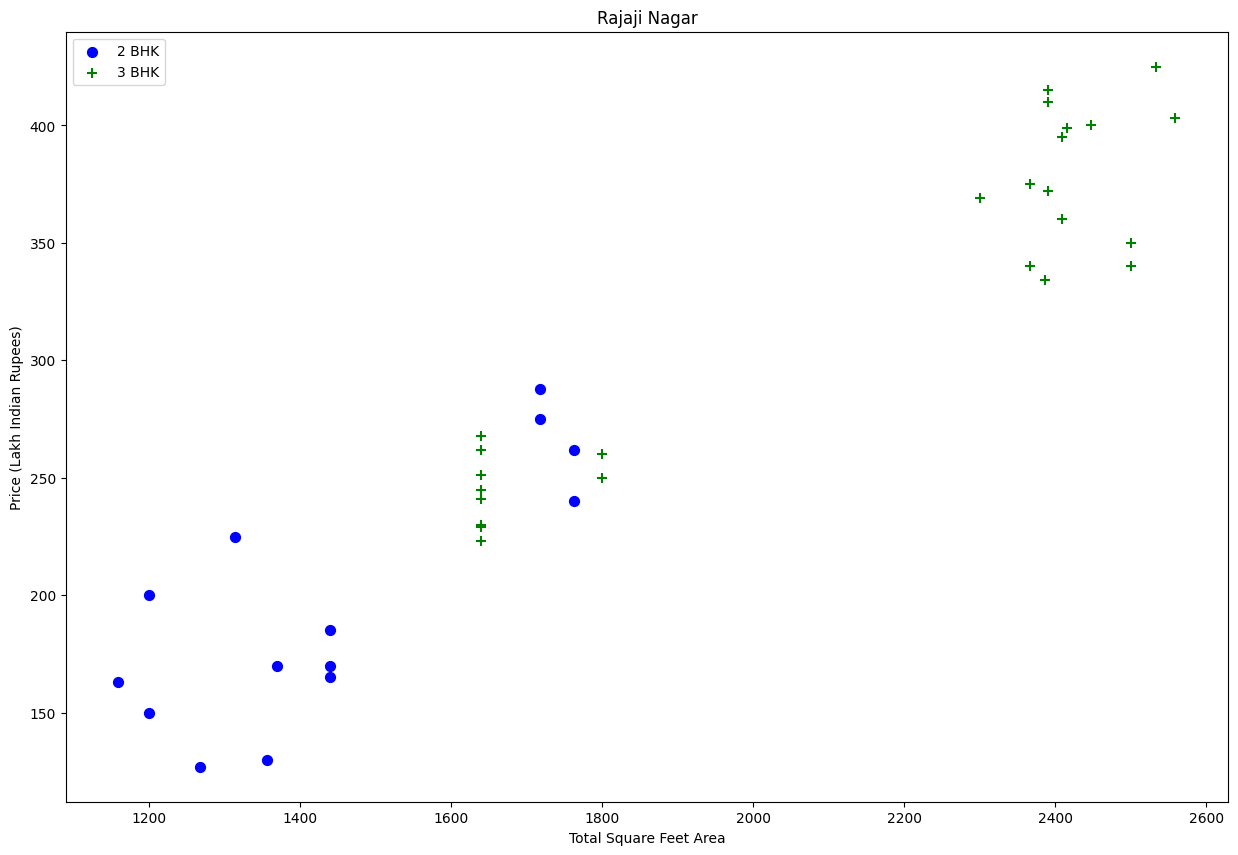

In [207]:
plot_scatter_chart(df8,"Rajaji Nagar")

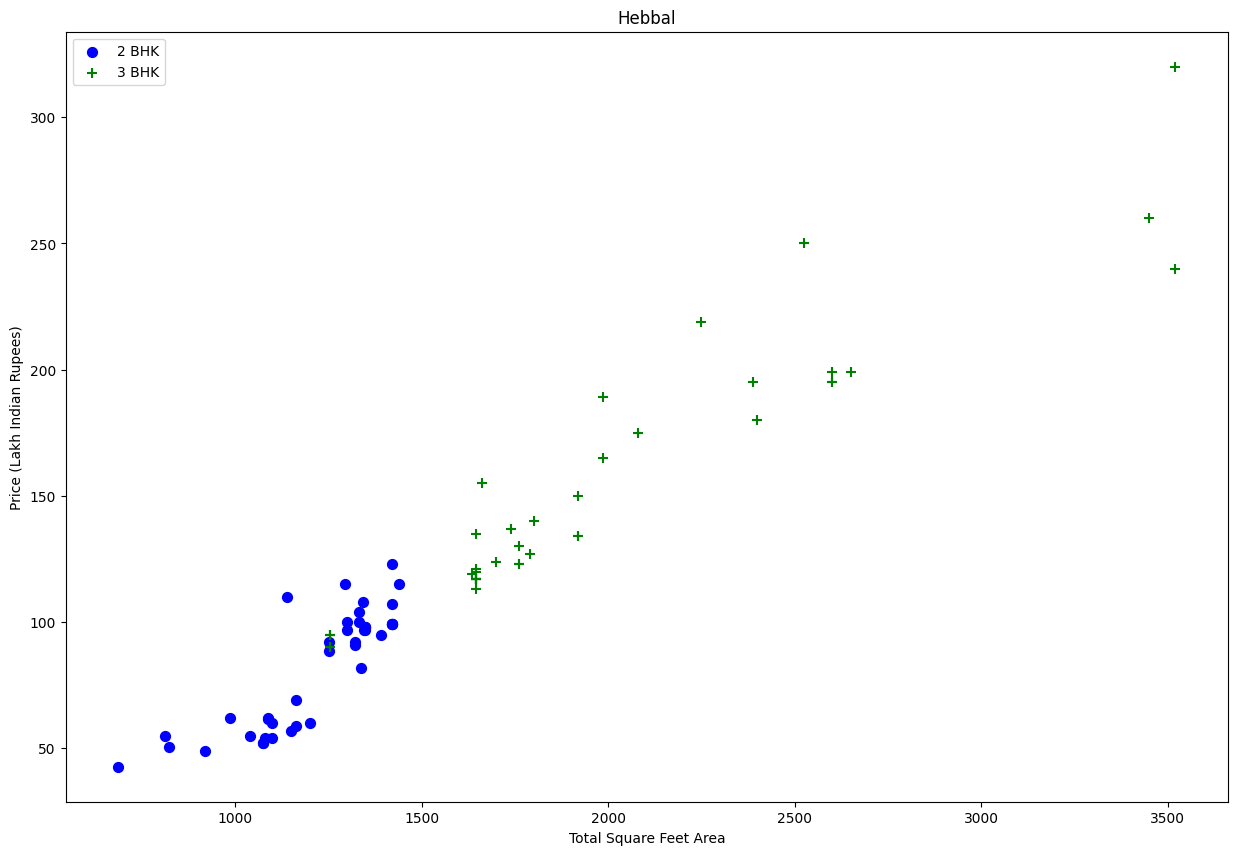

In [208]:
plot_scatter_chart(df8,"Hebbal")

Based on above charts we can see that data points highlighted in red below are outliers and they are being removed due to remove_bhk_outliers function

<h3 style='color:green'>Before and after outlier removal: Rajaji Nagar</h3>

<h3 style='color:green'>Before and after outlier removal: Hebbal</h3>

Text(0, 0.5, 'Count')

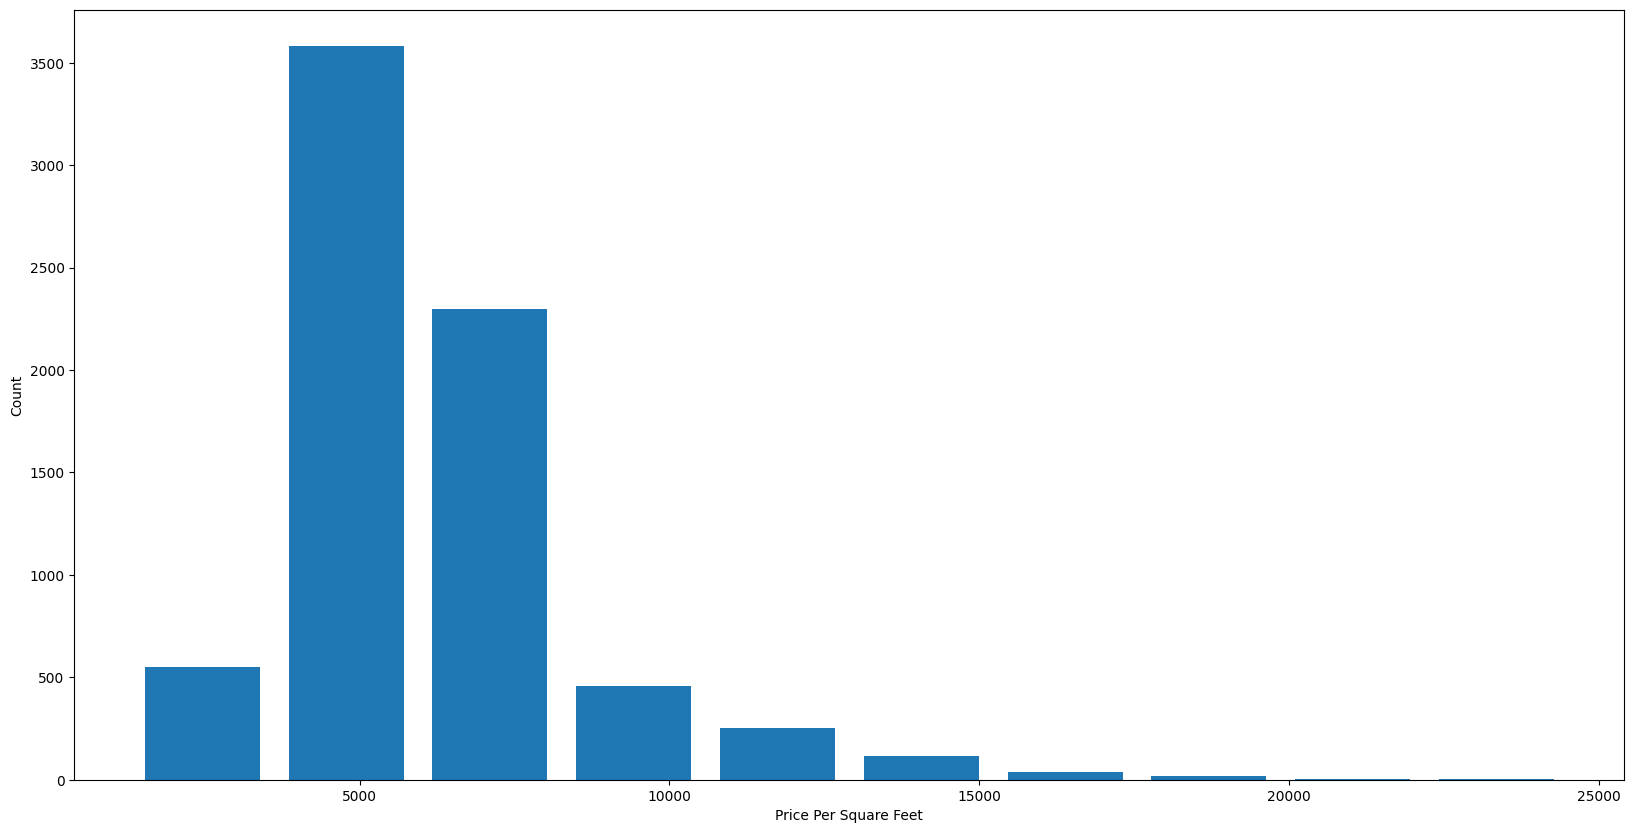

In [209]:
import matplotlib
matplotlib.rcParams["figure.figsize"] = (20,10)
plt.hist(df8.price_per_sqft,rwidth=0.8)
plt.xlabel("Price Per Square Feet")
plt.ylabel("Count")

<h2 style='color:blue'>Outlier Removal Using Bathrooms Feature</h2>

In [210]:
df8.bath.unique()

array([ 4.,  3.,  2.,  5.,  8.,  1.,  6.,  7.,  9., 12., 16., 13.])

Text(0, 0.5, 'Count')

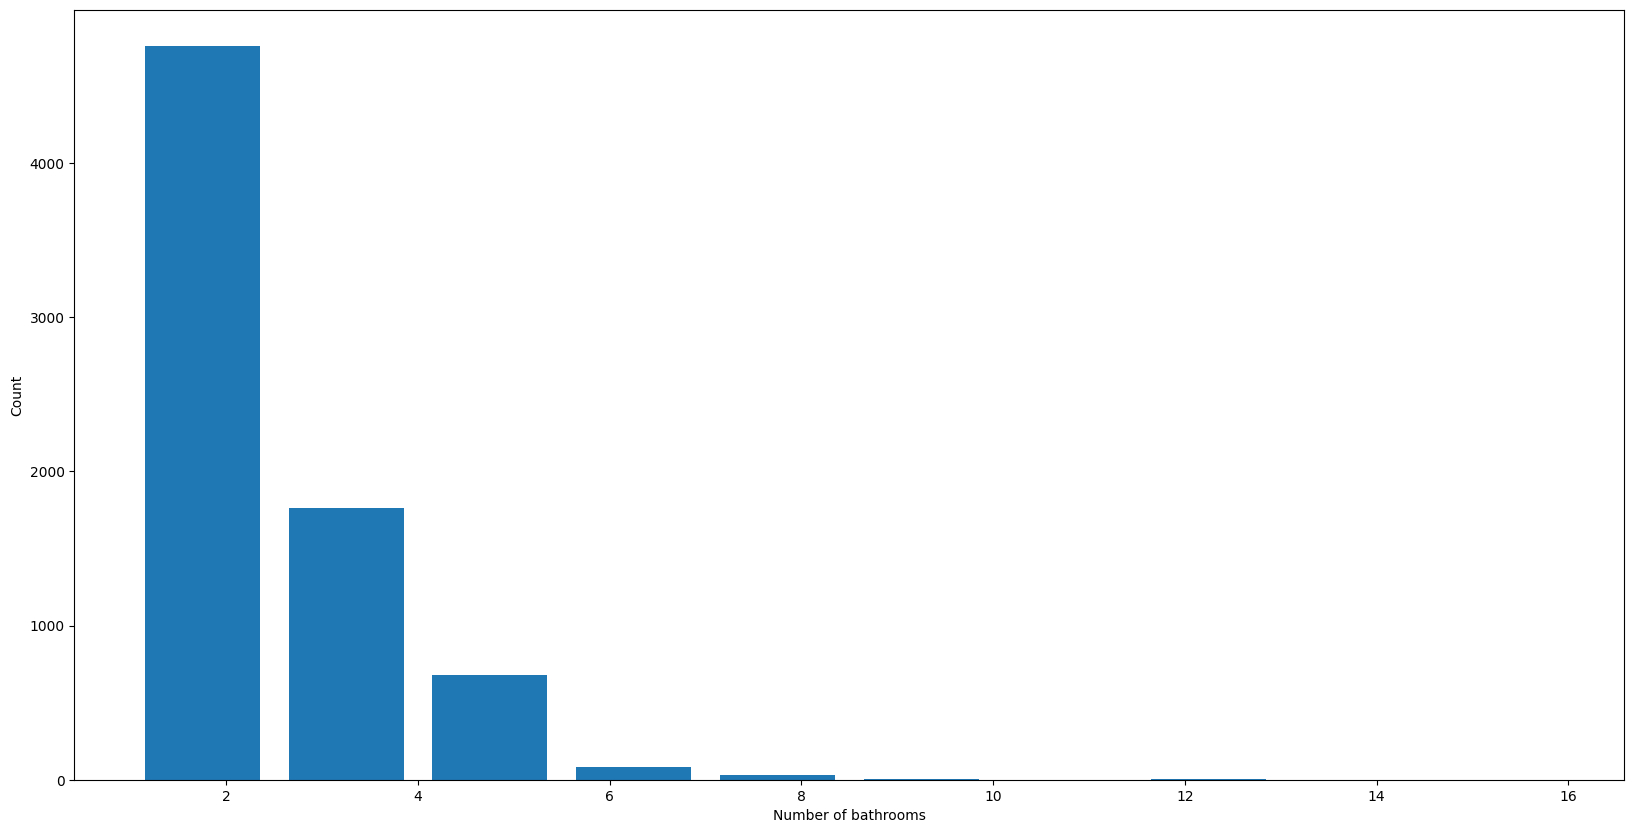

In [211]:
plt.hist(df8.bath,rwidth=0.8)
plt.xlabel("Number of bathrooms")
plt.ylabel("Count")

In [212]:
df8[df8.bath>10]

,location,size,total_sqft,bath,price,bhk,price_per_sqft
5277,Neeladri Nagar,10 BHK,4000.0,12.0,160.0,10,4000.000000
8483,other,10 BHK,12000.0,12.0,525.0,10,4375.000000
8572,other,16 BHK,10000.0,16.0,550.0,16,5500.000000
9306,other,11 BHK,6000.0,12.0,150.0,11,2500.000000
9637,other,13 BHK,5425.0,13.0,275.0,13,5069.124424


**It is unusual to have 2 more bathrooms than number of bedrooms in a home**

In [213]:
df8[df8.bath>df8.bhk+2]

,location,size,total_sqft,bath,price,bhk,price_per_sqft
1626,Chikkabanavar,4 Bedroom,2460.0,7.0,80.0,4,3252.032520
5238,Nagasandra,4 Bedroom,7000.0,8.0,450.0,4,6428.571429
6711,Thanisandra,3 BHK,1806.0,6.0,116.0,3,6423.034330
8408,other,6 BHK,11338.0,9.0,1000.0,6,8819.897689


**Again the business manager has a conversation with you (i.e. a data scientist) that if you have 4 bedroom home and even if you have bathroom in all 4 rooms plus one guest bathroom, you will have total bath = total bed + 1 max. Anything above that is an outlier or a data error and can be removed**

In [214]:
df9 = df8[df8.bath<df8.bhk+2]
df9.shape

(7239, 7)

In [215]:
df9.head(2)

,location,size,total_sqft,bath,price,bhk,price_per_sqft
0,1st Block Jayanagar,4 BHK,2850.0,4.0,428.0,4,15017.543860
1,1st Block Jayanagar,3 BHK,1630.0,3.0,194.0,3,11901.840491


In [216]:
df10 = df9.drop(['size','price_per_sqft'],axis='columns')
df10.head(3)

,location,total_sqft,bath,price,bhk
0,1st Block Jayanagar,2850.0,4.0,428.0,4
1,1st Block Jayanagar,1630.0,3.0,194.0,3
2,1st Block Jayanagar,1875.0,2.0,235.0,3


<h2 style='color:blue'>Use One Hot Encoding For Location</h2>

In [217]:
dummies = pd.get_dummies(df10.location)
dummies.head(3)

,1st Block Jayanagar,1st Phase JP Nagar,2nd Phase Judicial Layout,2nd Stage Nagarbhavi,5th Block Hbr Layout,5th Phase JP Nagar,6th Phase JP Nagar,7th Phase JP Nagar,8th Phase JP Nagar,9th Phase JP Nagar,AECS Layout,Abbigere,Akshaya Nagar,Ambalipura,Ambedkar Nagar,Amruthahalli,Anandapura,Ananth Nagar,Anekal,Anjanapura,Ardendale,Arekere,Attibele,BEML Layout,BTM 2nd Stage,BTM Layout,Babusapalaya,Badavala Nagar,Balagere,Banashankari,Banashankari Stage II,Banashankari Stage III,Banashankari Stage V,Banashankari Stage VI,Banaswadi,Banjara Layout,Bannerghatta,Bannerghatta Road,Basavangudi,Basaveshwara Nagar,Battarahalli,Begur,Begur Road,Bellandur,Benson Town,Bharathi Nagar,Bhoganhalli,Billekahalli,Binny Pete,Bisuvanahalli,Bommanahalli,Bommasandra,Bommasandra Industrial Area,Bommenahalli,Brookefield,Budigere,CV Raman Nagar,Chamrajpet,Chandapura,Channasandra,Chikka Tirupathi,Chikkabanavar,Chikkalasandra,Choodasandra,Cooke Town,Cox Town,Cunningham Road,Dasanapura,Dasarahalli,Devanahalli,Devarachikkanahalli,Dodda Nekkundi,Doddaballapur,Doddakallasandra,Doddathoguru,Domlur,Dommasandra,EPIP Zone,Electronic City,Electronic City Phase II,Electronics City Phase 1,Frazer Town,GM Palaya,Garudachar Palya,Giri Nagar,Gollarapalya Hosahalli,Gottigere,Green Glen Layout,Gubbalala,Gunjur,HAL 2nd Stage,HBR Layout,HRBR Layout,HSR Layout,Haralur Road,Harlur,Hebbal,Hebbal Kempapura,Hegde Nagar,Hennur,Hennur Road,Hoodi,Horamavu Agara,Horamavu Banaswadi,Hormavu,Hosa Road,Hosakerehalli,Hoskote,Hosur Road,Hulimavu,ISRO Layout,ITPL,Iblur Village,Indira Nagar,JP Nagar,Jakkur,Jalahalli,Jalahalli East,Jigani,Judicial Layout,KR Puram,Kadubeesanahalli,Kadugodi,Kaggadasapura,Kaggalipura,Kaikondrahalli,Kalena Agrahara,Kalyan nagar,Kambipura,Kammanahalli,Kammasandra,Kanakapura,Kanakpura Road,Kannamangala,Karuna Nagar,Kasavanhalli,Kasturi Nagar,Kathriguppe,Kaval Byrasandra,Kenchenahalli,Kengeri,Kengeri Satellite Town,Kereguddadahalli,Kodichikkanahalli,Kodigehaali,Kodigehalli,Kodihalli,Kogilu,Konanakunte,Koramangala,Kothannur,Kothanur,Kudlu,Kudlu Gate,Kumaraswami Layout,Kundalahalli,LB Shastri Nagar,Laggere,Lakshminarayana Pura,Lingadheeranahalli,Magadi Road,Mahadevpura,Mahalakshmi Layout,Mallasandra,Malleshpalya,Malleshwaram,Marathahalli,Margondanahalli,Marsur,Mico Layout,Munnekollal,Murugeshpalya,Mysore Road,NGR Layout,NRI Layout,Nagarbhavi,Nagasandra,Nagavara,Nagavarapalya,Narayanapura,Neeladri Nagar,Nehru Nagar,OMBR Layout,Old Airport Road,Old Madras Road,Padmanabhanagar,Pai Layout,Panathur,Parappana Agrahara,Pattandur Agrahara,Poorna Pragna Layout,Prithvi Layout,R.T. Nagar,Rachenahalli,Raja Rajeshwari Nagar,Rajaji Nagar,Rajiv Nagar,Ramagondanahalli,Ramamurthy Nagar,Rayasandra,Sahakara Nagar,Sanjay nagar,Sarakki Nagar,Sarjapur,Sarjapur Road,Sarjapura - Attibele Road,Sector 2 HSR Layout,Sector 7 HSR Layout,Seegehalli,Shampura,Shivaji Nagar,Singasandra,Somasundara Palya,Sompura,Sonnenahalli,Subramanyapura,Sultan Palaya,TC Palaya,Talaghattapura,Thanisandra,Thigalarapalya,Thubarahalli,Tindlu,Tumkur Road,Ulsoor,Uttarahalli,Varthur,Varthur Road,Vasanthapura,Vidyaranyapura,Vijayanagar,Vishveshwarya Layout,Vishwapriya Layout,Vittasandra,Whitefield,Yelachenahalli,Yelahanka,Yelahanka New Town,Yelenahalli,Yeshwanthpur,other
0,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,Fals

In [218]:
df11 = pd.concat([df10,dummies.drop('other',axis='columns')],axis='columns')
df11.head()

,location,total_sqft,bath,price,bhk,1st Block Jayanagar,1st Phase JP Nagar,2nd Phase Judicial Layout,2nd Stage Nagarbhavi,5th Block Hbr Layout,5th Phase JP Nagar,6th Phase JP Nagar,7th Phase JP Nagar,8th Phase JP Nagar,9th Phase JP Nagar,AECS Layout,Abbigere,Akshaya Nagar,Ambalipura,Ambedkar Nagar,Amruthahalli,Anandapura,Ananth Nagar,Anekal,Anjanapura,Ardendale,Arekere,Attibele,BEML Layout,BTM 2nd Stage,BTM Layout,Babusapalaya,Badavala Nagar,Balagere,Banashankari,Banashankari Stage II,Banashankari Stage III,Banashankari Stage V,Banashankari Stage VI,Banaswadi,Banjara Layout,Bannerghatta,Bannerghatta Road,Basavangudi,Basaveshwara Nagar,Battarahalli,Begur,Begur Road,Bellandur,Benson Town,Bharathi Nagar,Bhoganhalli,Billekahalli,Binny Pete,Bisuvanahalli,Bommanahalli,Bommasandra,Bommasandra Industrial Area,Bommenahalli,Brookefield,Budigere,CV Raman Nagar,Chamrajpet,Chandapura,Channasandra,Chikka Tirupathi,Chikkabanavar,Chikkalasandra,Choodasandra,Cooke Town,Cox Town,Cunningham Road,Dasanapura,Dasarahalli,Devanahalli,Devarachikkanahalli,Dodda Nekkundi,Doddaballapur,Doddakallasandra,Doddathoguru,Domlur,Dommasandra,EPIP Zone,Electronic City,Electronic City Phase II,Electronics City Phase 1,Frazer Town,GM Palaya,Garudachar Palya,Giri Nagar,Gollarapalya Hosahalli,Gottigere,Green Glen Layout,Gubbalala,Gunjur,HAL 2nd Stage,HBR Layout,HRBR Layout,HSR Layout,Haralur Road,Harlur,Hebbal,Hebbal Kempapura,Hegde Nagar,Hennur,Hennur Road,Hoodi,Horamavu Agara,Horamavu Banaswadi,Hormavu,Hosa Road,Hosakerehalli,Hoskote,Hosur Road,Hulimavu,ISRO Layout,ITPL,Iblur Village,Indira Nagar,JP Nagar,Jakkur,Jalahalli,Jalahalli East,Jigani,Judicial Layout,KR Puram,Kadubeesanahalli,Kadugodi,Kaggadasapura,Kaggalipura,Kaikondrahalli,Kalena Agrahara,Kalyan nagar,Kambipura,Kammanahalli,Kammasandra,Kanakapura,Kanakpura Road,Kannamangala,Karuna Nagar,Kasavanhalli,Kasturi Nagar,Kathriguppe,Kaval Byrasandra,Kenchenahalli,Kengeri,Kengeri Satellite Town,Kereguddadahalli,Kodichikkanahalli,Kodigehaali,Kodigehalli,Kodihalli,Kogilu,Konanakunte,Koramangala,Kothannur,Kothanur,Kudlu,Kudlu Gate,Kumaraswami Layout,Kundalahalli,LB Shastri Nagar,Laggere,Lakshminarayana Pura,Lingadheeranahalli,Magadi Road,Mahadevpura,Mahalakshmi Layout,Mallasandra,Malleshpalya,Malleshwaram,Marathahalli,Margondanahalli,Marsur,Mico Layout,Munnekollal,Murugeshpalya,Mysore Road,NGR Layout,NRI Layout,Nagarbhavi,Nagasandra,Nagavara,Nagavarapalya,Narayanapura,Neeladri Nagar,Nehru Nagar,OMBR Layout,Old Airport Road,Old Madras Road,Padmanabhanagar,Pai Layout,Panathur,Parappana Agrahara,Pattandur Agrahara,Poorna Pragna Layout,Prithvi Layout,R.T. Nagar,Rachenahalli,Raja Rajeshwari Nagar,Rajaji Nagar,Rajiv Nagar,Ramagondanahalli,Ramamurthy Nagar,Rayasandra,Sahakara Nagar,Sanjay nagar,Sarakki Nagar,Sarjapur,Sarjapur Road,Sarjapura - Attibele Road,Sector 2 HSR Layout,Sector 7 HSR Layout,Seegehalli,Shampura,Shivaji Nagar,Singasandra,Somasundara Palya,Sompura,Sonnenahalli,Subramanyapura,Sultan Palaya,TC Palaya,Talaghattapura,Thanisandra,Thigalarapalya,Thubarahalli,Tindlu,Tumkur Road,Ulsoor,Uttarahalli,Varthur,Varthur Road,Vasanthapura,Vidyaranyapura,Vijayanagar,Vishveshwarya Layout,Vishwapriya Layout,Vittasandra,Whitefield,Yelachenahalli,Yelahanka,Yelahanka New Town,Yelenahalli,Yeshwanthpur
0,1st Block Jayanagar,2850.0,4.0,428.0,4,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,Fa

In [219]:
df12 = df11.drop('location',axis='columns')
df12.head(2)

,total_sqft,bath,price,bhk,1st Block Jayanagar,1st Phase JP Nagar,2nd Phase Judicial Layout,2nd Stage Nagarbhavi,5th Block Hbr Layout,5th Phase JP Nagar,6th Phase JP Nagar,7th Phase JP Nagar,8th Phase JP Nagar,9th Phase JP Nagar,AECS Layout,Abbigere,Akshaya Nagar,Ambalipura,Ambedkar Nagar,Amruthahalli,Anandapura,Ananth Nagar,Anekal,Anjanapura,Ardendale,Arekere,Attibele,BEML Layout,BTM 2nd Stage,BTM Layout,Babusapalaya,Badavala Nagar,Balagere,Banashankari,Banashankari Stage II,Banashankari Stage III,Banashankari Stage V,Banashankari Stage VI,Banaswadi,Banjara Layout,Bannerghatta,Bannerghatta Road,Basavangudi,Basaveshwara Nagar,Battarahalli,Begur,Begur Road,Bellandur,Benson Town,Bharathi Nagar,Bhoganhalli,Billekahalli,Binny Pete,Bisuvanahalli,Bommanahalli,Bommasandra,Bommasandra Industrial Area,Bommenahalli,Brookefield,Budigere,CV Raman Nagar,Chamrajpet,Chandapura,Channasandra,Chikka Tirupathi,Chikkabanavar,Chikkalasandra,Choodasandra,Cooke Town,Cox Town,Cunningham Road,Dasanapura,Dasarahalli,Devanahalli,Devarachikkanahalli,Dodda Nekkundi,Doddaballapur,Doddakallasandra,Doddathoguru,Domlur,Dommasandra,EPIP Zone,Electronic City,Electronic City Phase II,Electronics City Phase 1,Frazer Town,GM Palaya,Garudachar Palya,Giri Nagar,Gollarapalya Hosahalli,Gottigere,Green Glen Layout,Gubbalala,Gunjur,HAL 2nd Stage,HBR Layout,HRBR Layout,HSR Layout,Haralur Road,Harlur,Hebbal,Hebbal Kempapura,Hegde Nagar,Hennur,Hennur Road,Hoodi,Horamavu Agara,Horamavu Banaswadi,Hormavu,Hosa Road,Hosakerehalli,Hoskote,Hosur Road,Hulimavu,ISRO Layout,ITPL,Iblur Village,Indira Nagar,JP Nagar,Jakkur,Jalahalli,Jalahalli East,Jigani,Judicial Layout,KR Puram,Kadubeesanahalli,Kadugodi,Kaggadasapura,Kaggalipura,Kaikondrahalli,Kalena Agrahara,Kalyan nagar,Kambipura,Kammanahalli,Kammasandra,Kanakapura,Kanakpura Road,Kannamangala,Karuna Nagar,Kasavanhalli,Kasturi Nagar,Kathriguppe,Kaval Byrasandra,Kenchenahalli,Kengeri,Kengeri Satellite Town,Kereguddadahalli,Kodichikkanahalli,Kodigehaali,Kodigehalli,Kodihalli,Kogilu,Konanakunte,Koramangala,Kothannur,Kothanur,Kudlu,Kudlu Gate,Kumaraswami Layout,Kundalahalli,LB Shastri Nagar,Laggere,Lakshminarayana Pura,Lingadheeranahalli,Magadi Road,Mahadevpura,Mahalakshmi Layout,Mallasandra,Malleshpalya,Malleshwaram,Marathahalli,Margondanahalli,Marsur,Mico Layout,Munnekollal,Murugeshpalya,Mysore Road,NGR Layout,NRI Layout,Nagarbhavi,Nagasandra,Nagavara,Nagavarapalya,Narayanapura,Neeladri Nagar,Nehru Nagar,OMBR Layout,Old Airport Road,Old Madras Road,Padmanabhanagar,Pai Layout,Panathur,Parappana Agrahara,Pattandur Agrahara,Poorna Pragna Layout,Prithvi Layout,R.T. Nagar,Rachenahalli,Raja Rajeshwari Nagar,Rajaji Nagar,Rajiv Nagar,Ramagondanahalli,Ramamurthy Nagar,Rayasandra,Sahakara Nagar,Sanjay nagar,Sarakki Nagar,Sarjapur,Sarjapur Road,Sarjapura - Attibele Road,Sector 2 HSR Layout,Sector 7 HSR Layout,Seegehalli,Shampura,Shivaji Nagar,Singasandra,Somasundara Palya,Sompura,Sonnenahalli,Subramanyapura,Sultan Palaya,TC Palaya,Talaghattapura,Thanisandra,Thigalarapalya,Thubarahalli,Tindlu,Tumkur Road,Ulsoor,Uttarahalli,Varthur,Varthur Road,Vasanthapura,Vidyaranyapura,Vijayanagar,Vishveshwarya Layout,Vishwapriya Layout,Vittasandra,Whitefield,Yelachenahalli,Yelahanka,Yelahanka New Town,Yelenahalli,Yeshwanthpur
0,2850.0,4.0,428.0,4,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,F

<h2 style='color:blue'>Build a Model Now...</h2>

In [220]:
df12.shape

(7239, 244)

In [221]:
X = df12.drop(['price'],axis='columns')
X.head(3)

,total_sqft,bath,bhk,1st Block Jayanagar,1st Phase JP Nagar,2nd Phase Judicial Layout,2nd Stage Nagarbhavi,5th Block Hbr Layout,5th Phase JP Nagar,6th Phase JP Nagar,7th Phase JP Nagar,8th Phase JP Nagar,9th Phase JP Nagar,AECS Layout,Abbigere,Akshaya Nagar,Ambalipura,Ambedkar Nagar,Amruthahalli,Anandapura,Ananth Nagar,Anekal,Anjanapura,Ardendale,Arekere,Attibele,BEML Layout,BTM 2nd Stage,BTM Layout,Babusapalaya,Badavala Nagar,Balagere,Banashankari,Banashankari Stage II,Banashankari Stage III,Banashankari Stage V,Banashankari Stage VI,Banaswadi,Banjara Layout,Bannerghatta,Bannerghatta Road,Basavangudi,Basaveshwara Nagar,Battarahalli,Begur,Begur Road,Bellandur,Benson Town,Bharathi Nagar,Bhoganhalli,Billekahalli,Binny Pete,Bisuvanahalli,Bommanahalli,Bommasandra,Bommasandra Industrial Area,Bommenahalli,Brookefield,Budigere,CV Raman Nagar,Chamrajpet,Chandapura,Channasandra,Chikka Tirupathi,Chikkabanavar,Chikkalasandra,Choodasandra,Cooke Town,Cox Town,Cunningham Road,Dasanapura,Dasarahalli,Devanahalli,Devarachikkanahalli,Dodda Nekkundi,Doddaballapur,Doddakallasandra,Doddathoguru,Domlur,Dommasandra,EPIP Zone,Electronic City,Electronic City Phase II,Electronics City Phase 1,Frazer Town,GM Palaya,Garudachar Palya,Giri Nagar,Gollarapalya Hosahalli,Gottigere,Green Glen Layout,Gubbalala,Gunjur,HAL 2nd Stage,HBR Layout,HRBR Layout,HSR Layout,Haralur Road,Harlur,Hebbal,Hebbal Kempapura,Hegde Nagar,Hennur,Hennur Road,Hoodi,Horamavu Agara,Horamavu Banaswadi,Hormavu,Hosa Road,Hosakerehalli,Hoskote,Hosur Road,Hulimavu,ISRO Layout,ITPL,Iblur Village,Indira Nagar,JP Nagar,Jakkur,Jalahalli,Jalahalli East,Jigani,Judicial Layout,KR Puram,Kadubeesanahalli,Kadugodi,Kaggadasapura,Kaggalipura,Kaikondrahalli,Kalena Agrahara,Kalyan nagar,Kambipura,Kammanahalli,Kammasandra,Kanakapura,Kanakpura Road,Kannamangala,Karuna Nagar,Kasavanhalli,Kasturi Nagar,Kathriguppe,Kaval Byrasandra,Kenchenahalli,Kengeri,Kengeri Satellite Town,Kereguddadahalli,Kodichikkanahalli,Kodigehaali,Kodigehalli,Kodihalli,Kogilu,Konanakunte,Koramangala,Kothannur,Kothanur,Kudlu,Kudlu Gate,Kumaraswami Layout,Kundalahalli,LB Shastri Nagar,Laggere,Lakshminarayana Pura,Lingadheeranahalli,Magadi Road,Mahadevpura,Mahalakshmi Layout,Mallasandra,Malleshpalya,Malleshwaram,Marathahalli,Margondanahalli,Marsur,Mico Layout,Munnekollal,Murugeshpalya,Mysore Road,NGR Layout,NRI Layout,Nagarbhavi,Nagasandra,Nagavara,Nagavarapalya,Narayanapura,Neeladri Nagar,Nehru Nagar,OMBR Layout,Old Airport Road,Old Madras Road,Padmanabhanagar,Pai Layout,Panathur,Parappana Agrahara,Pattandur Agrahara,Poorna Pragna Layout,Prithvi Layout,R.T. Nagar,Rachenahalli,Raja Rajeshwari Nagar,Rajaji Nagar,Rajiv Nagar,Ramagondanahalli,Ramamurthy Nagar,Rayasandra,Sahakara Nagar,Sanjay nagar,Sarakki Nagar,Sarjapur,Sarjapur Road,Sarjapura - Attibele Road,Sector 2 HSR Layout,Sector 7 HSR Layout,Seegehalli,Shampura,Shivaji Nagar,Singasandra,Somasundara Palya,Sompura,Sonnenahalli,Subramanyapura,Sultan Palaya,TC Palaya,Talaghattapura,Thanisandra,Thigalarapalya,Thubarahalli,Tindlu,Tumkur Road,Ulsoor,Uttarahalli,Varthur,Varthur Road,Vasanthapura,Vidyaranyapura,Vijayanagar,Vishveshwarya Layout,Vishwapriya Layout,Vittasandra,Whitefield,Yelachenahalli,Yelahanka,Yelahanka New Town,Yelenahalli,Yeshwanthpur
0,2850.0,4.0,4,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,F

In [222]:
X.shape

(7239, 243)

In [223]:
y = df12.price
y.head(3)

,price
0,428.0
1,194.0
2,235.0


In [224]:
len(y)

7239

## <a id='regression'></a> Regression Model (Applied Correctly)

In [225]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=10)

In [226]:
linreg = LinearRegression()
linreg.fit(X_train, y_train)

y_pred = linreg.predict(X_test)

## <a id='evaluation'></a> Model Evaluation Metrics & Clean Visualizations

In [227]:
# Numeric metrics
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print(f"MAE: {mae:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"R²: {r2:.3f}")

MAE: 16.16
RMSE: 26.67
R²: 0.863


<h2 style='color:blue'>Test the model for few properties</h2>

In [228]:
def predict_price(location,sqft,bath,bhk):
    loc_index = np.where(X.columns==location)[0][0]

    x = np.zeros(len(X.columns))
    x[0] = sqft
    x[1] = bath
    x[2] = bhk
    if loc_index >= 0:
        x[loc_index] = 1

    return linreg.predict([x])[0]

In [229]:
predict_price('1st Phase JP Nagar',1000, 2, 2)

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


np.float64(83.86570258311667)

<h2 style='color:blue'>Export the tested model to a pickle file</h2>

In [230]:
import pickle
with open('banglore_home_prices_model.pickle','wb') as f:
    pickle.dump(linreg,f)

<h2 style='color:blue'>Export location and column information to a file that will be useful later on in our prediction application</h2>

In [231]:
import json
columns = {
    'data_columns' : [col.lower() for col in X.columns]
}
with open("columns.json","w") as f:
    f.write(json.dumps(columns))

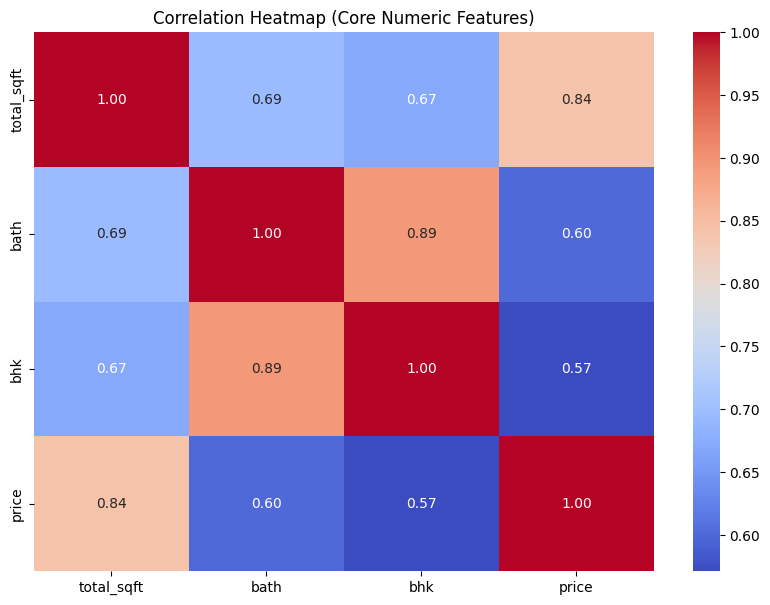

In [232]:
# Correlation Heatmap (effective visualization)
plt.figure(figsize=(10,7))
sns.heatmap(df12[['total_sqft','bath','bhk','price']].corr(), annot=True, fmt='.2f', cmap='coolwarm')
plt.title('Correlation Heatmap (Core Numeric Features)')
plt.show()

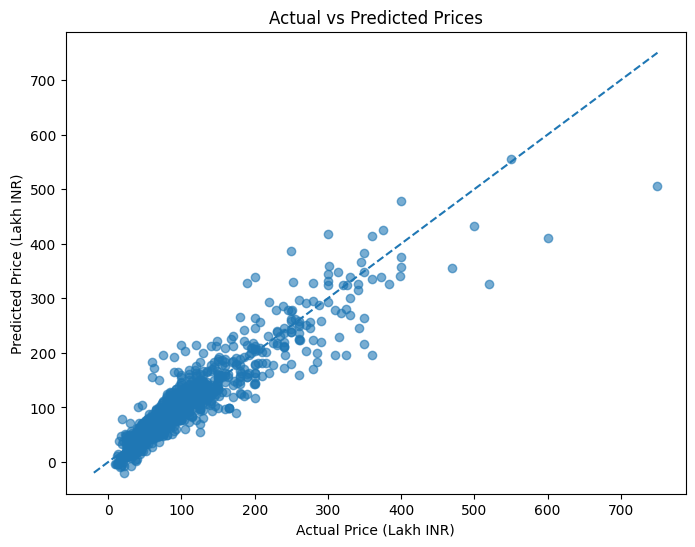

In [233]:
# Actual vs Predicted chart
plt.figure(figsize=(8,6))
plt.scatter(y_test, y_pred, alpha=0.6)
min_v = min(y_test.min(), y_pred.min())
max_v = max(y_test.max(), y_pred.max())
plt.plot([min_v, max_v], [min_v, max_v], linestyle='--')
plt.xlabel('Actual Price (Lakh INR)')
plt.ylabel('Predicted Price (Lakh INR)')
plt.title('Actual vs Predicted Prices')
plt.show()

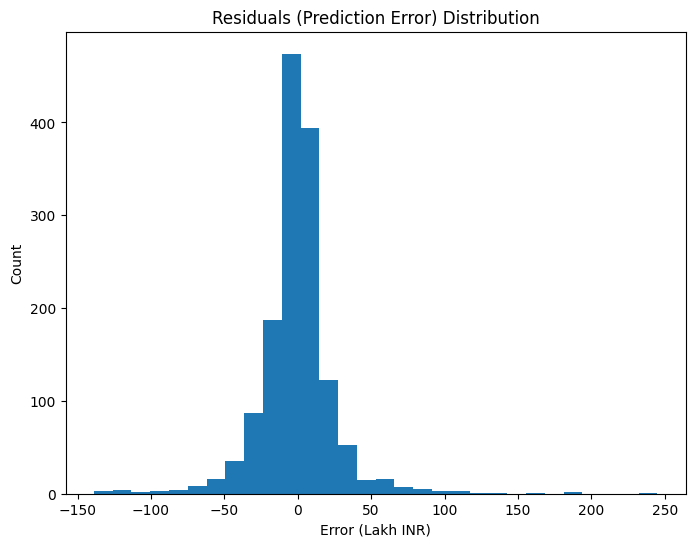

In [234]:
# Residuals distribution
residuals = y_test - y_pred
plt.figure(figsize=(8,6))
plt.hist(residuals, bins=30)
plt.title('Residuals (Prediction Error) Distribution')
plt.xlabel('Error (Lakh INR)')
plt.ylabel('Count')
plt.show()

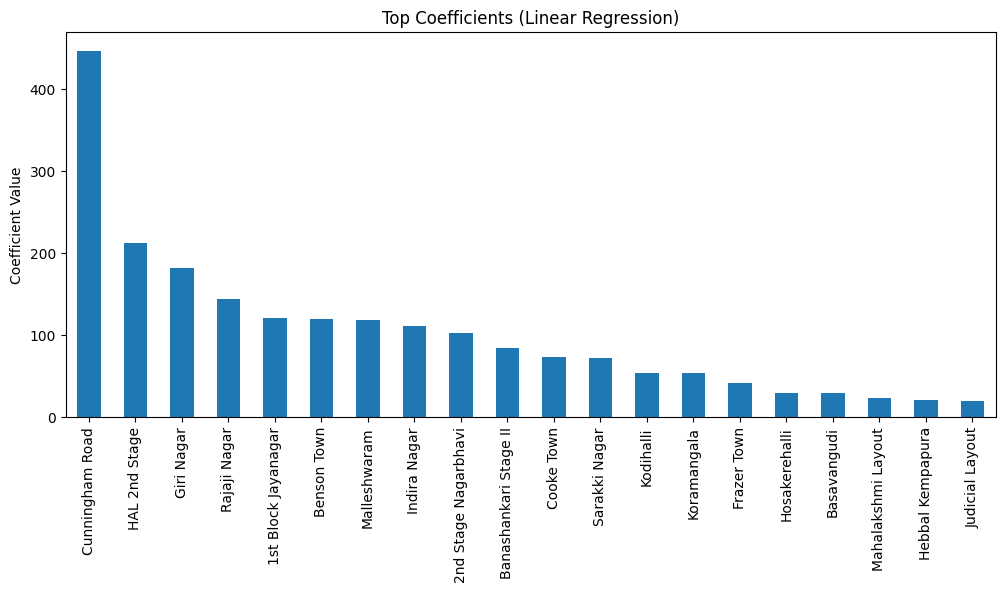

In [235]:
# Feature importance for Linear Regression (absolute coefficients)
coefs = pd.Series(linreg.coef_, index=X.columns).sort_values(ascending=False)
coefs.head(20).plot(kind='bar', figsize=(12,5), title='Top Coefficients (Linear Regression)')
plt.ylabel('Coefficient Value')
plt.show()

## <a id='classification'></a> Bonus: Classification to Produce Confusion Matrix & Accuracy

In [236]:
# Create price bands (quartiles)
price_bins = pd.qcut(df12['price'], q=4, labels=['Low','Mid','High','Premium'])
df_cls = df12.copy()
df_cls['price_band'] = price_bins

Xc = df_cls.drop(columns=['price','price_band'])
yc = df_cls['price_band']

Xc_train, Xc_test, yc_train, yc_test = train_test_split(
    Xc, yc, test_size=0.2, random_state=42, stratify=yc
)

clf = RandomForestClassifier(n_estimators=200, random_state=42)
clf.fit(Xc_train, yc_train)
yc_pred = clf.predict(Xc_test)

acc = accuracy_score(yc_test, yc_pred)
print('Accuracy:', round(acc, 3))
print('\nClassification Report:\n', classification_report(yc_test, yc_pred))

Accuracy: 0.748

Classification Report:
               precision    recall  f1-score   support

        High       0.66      0.73      0.69       369
         Low       0.85      0.78      0.81       373
         Mid       0.67      0.62      0.64       351
     Premium       0.83      0.87      0.85       355

    accuracy                           0.75      1448
   macro avg       0.75      0.75      0.75      1448
weighted avg       0.75      0.75      0.75      1448



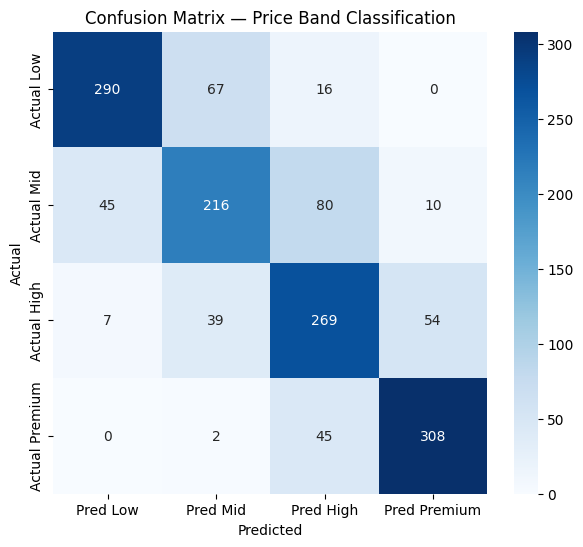

In [237]:
# Confusion Matrix Heatmap
cm = confusion_matrix(yc_test, yc_pred, labels=['Low','Mid','High','Premium'])
cm_df = pd.DataFrame(cm, index=['Actual Low','Actual Mid','Actual High','Actual Premium'],
                        columns=['Pred Low','Pred Mid','Pred High','Pred Premium'])
plt.figure(figsize=(7,6))
sns.heatmap(cm_df, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix — Price Band Classification')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

## <a id='geo'></a> Location Insights & Geospatial Mapping (Placeholder)

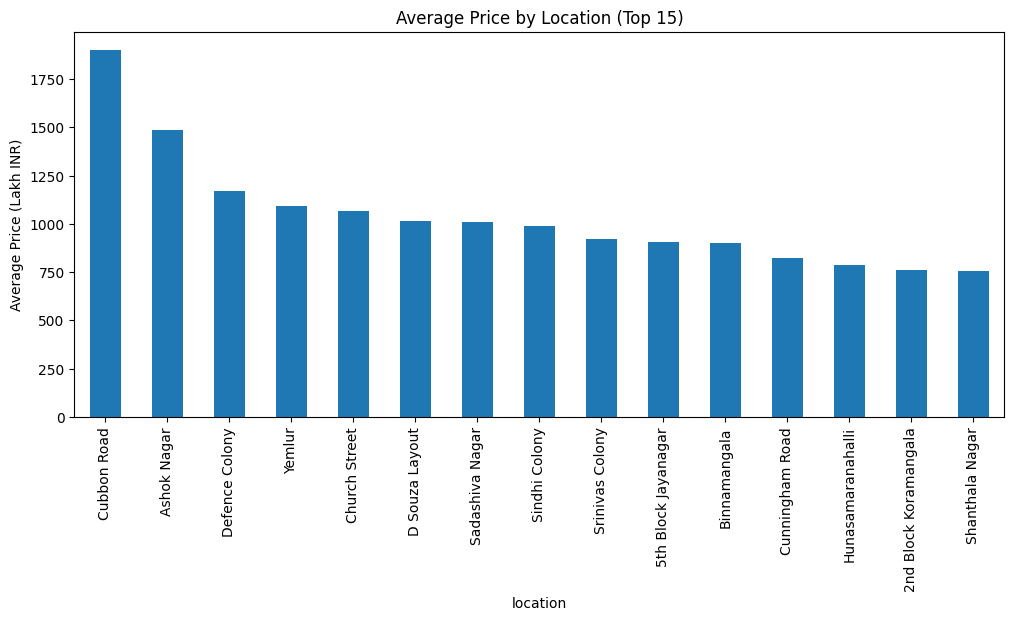

In [238]:
# Average price by top 15 locations (useful if geospatial coords unavailable)
loc_price = df1.groupby('location')['price'].mean().sort_values(ascending=False).head(15)
loc_price.plot(kind='bar', figsize=(12,5), title='Average Price by Location (Top 15)')
plt.ylabel('Average Price (Lakh INR)')
plt.show()